### Background:

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

### Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

### Attributes:
id : unique identifier for candidate (numeric)

job_title : job title for candidate (text)

location : geographical location for candidate (text)

connections: number of connections candidate has, 500+ means over 500 (text)

### Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”

### Goal(s):

Predict how fit the candidate is based on their available information (variable fit)

### Success Metric(s):

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

### Bonus(es):

We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.

How can we filter out candidates which in the first place should not be in this list?

Can we determine a cut-off point that would work for other roles without losing high potential candidates?

Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

## Import Libraries and Load Dataset

In [1]:
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

import warnings

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import scipy.stats as stats

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine


import shutil
import re
import string
import spacy
import os
import wget

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
import gensim.downloader as api
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from gensim.models.doc2vec import Doc2Vec

from sentence_transformers import SentenceTransformer

from src.features.build_features import text_processing as tp
from src.features.add_features import features as feat
from src.models.train_model import similarity_models as sim
from src.data.make_dataset import load_embeddings as load
from src.models.get_embeddings import embeddings as embedd

print('_________________All Libraries Have Been Installed.__________________')

C:\Users\The Lion\anaconda3\envs\potential_talents\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


_________________All Libraries Have Been Installed.__________________


[nltk_data] Downloading package stopwords to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\The
[nltk_data]     Lion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C

In [2]:
dataset = pd.read_csv('../data/raw/potential-talents - Aspiring human resources - seeking human resources.csv')

In [3]:
dataset.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [4]:
dataset.shape

(104, 5)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


In [6]:
#some basic stats for categorical columns
dataset.describe(include=object)

,job_title,location,connection
count,104,104,104
unique,52,41,33
top,2019 C.T. Bauer College of Business Graduate (...,Kanada,500+
freq,7,12,44


# Analysis

- Dropping id column as we don't need it.

- job_title- This column contains all job titles.

- location- This column contains location of all candidates.

- connection- This column contains the number of connections each candidate has.

In [7]:
#droping Id column as we don't need it.
dataset = dataset.drop(['id'], axis=1)
dataset.shape

(104, 4)

### Now we will check for any null values or dubplicated rows.

In [8]:
#checking for null values
dataset.isnull().sum()

job_title       0
location        0
connection      0
fit           104
dtype: int64

In [9]:
#Checking for dublicate values
dataset.duplicated().sum()

51

In [10]:
dataset.shape

(104, 4)

In [11]:
dataset

,job_title,location,connection,fit
0,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
...,...,...,...,...
99,Aspiring Human Resources Manager | Graduating ...,"Cape Girardeau, Missouri",103,NaN
100,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,NaN
101,Business Intelligence and Analytics at Travelers,Greater New York City Area,49,NaN
102,Always set them up for Success,Greater Los Angeles Area,500+,NaN


In [12]:
#removing duplicate rows
dataset = dataset.drop_duplicates()
dataset.shape

(53, 4)

## Analysis

- There are no null values in columns.
- There are total 51 duplicated rows which are removed.

# Text Preprocessing

In [13]:
dataset = tp.preprocessing_data(dataset)

============Before Preprocessing=============
job_title 1:
 2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
job_title 2:
 Native English Teacher at EPIK (English Program in Korea)
job_title 3:
 Aspiring Human Resources Professional
job_title 4:
 People Development Coordinator at Ryan
job_title 5:
 Advisory Board Member at Celal Bayar University
============After Preprocessing=============
job_title 1:
 ct bauer college business graduate magna cum laude aspiring human resources professional
job_title 2:
 native english teacher epik english program korea
job_title 3:
 aspiring human resources professional
job_title 4:
 people development coordinator ryan
job_title 5:
 advisory board member celal bayar university


## Analysis
- Above function is used to remove punctuations, white spaces, stopwords, numbers, and to lowercase the words.
- Lemmetaization is used here because of its contextual benefit.
- Connection column has also been changed from object type to int as it will be required for final score calculation.

## Exploratory Data Analysis

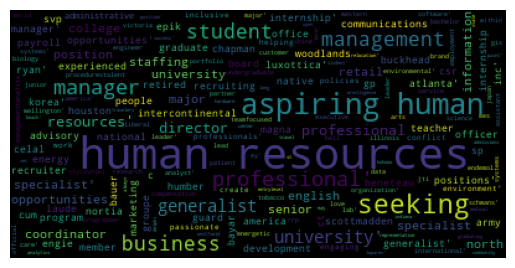

In [14]:
text = dataset['job_title'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Analysis
- above word cloud shows that there are more job titles with asipiring human resources than with seeking human resources.

# Embeddings and Similarity

In [15]:
# These are the search keys to be used for similarity
search_keys = ['aspiring human resources', 'seeking human resources']

## Jaccard Similarity 

In [16]:
jaccard_score = []
for job in list(dataset['job_title']):
    score_jac_1 = sim.Jaccard_Similarity(job,search_keys[0])
    score_jac_2 = sim.Jaccard_Similarity(job,search_keys[1])
    jaccard_score.append((score_jac_1+score_jac_2)/2)

dataset['Jaccard Score'] = jaccard_score

In [17]:
dataset.sort_values(by=['Jaccard Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000
73,human resources professional,Greater Boston Area,16,NaN,0.500000
72,aspiring human resources manager seeking inter...,"Houston, Texas Area",7,NaN,0.500000
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.466667
26,aspiring human resources management student se...,"Houston, Texas Area",500,NaN,0.428571
77,human resources generalist schwans,Amerika Birleşik Devletleri,500,NaN,0.400000


## GloVe Embeddings

### Download and unzip  pre trained GloVe embeddings

In [18]:
glove_model = load.load_pretrained_glove()

### Now We can get GloVe embedding vectors for our text data.

In [19]:
glove_vectors = embedd.get_glove_embeddings(list(dataset['job_title']),glove_model)
search_vectors = embedd.get_glove_embeddings(search_keys,glove_model)

At this step we calculate cosine similarity for every job title with respect to both search vectors.
Cosine similatry will return a matrix with similairty score with respect to each word, which will be flatten to generate an average final socre.

In [20]:
print(len(glove_vectors))

53


### Cosine similarity with GloVe Embeddings

In [21]:
# Cosine similarity
gloveScore = []
for i in range(len(glove_vectors)) :
    score1 = cosine_similarity(glove_vectors[i], search_vectors[0])
    score2 = cosine_similarity(glove_vectors[i], search_vectors[1])
    gloveScore.append((np.mean(score1.flatten())+np.mean(score2.flatten())/2))
    #print(gloveScore)
dataset['GloVe Score'] = gloveScore

In [22]:
dataset.sort_values(by=['GloVe Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000,0.858340
73,human resources professional,Greater Boston Area,16,NaN,0.500000,0.851835
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000,0.810357
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000,0.804556
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000,0.804556
87,human resources management major,"Milpitas, California",18,NaN,0.400000,0.792651
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.466667,0.786501
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000,0.781364
72,aspiring human resources manager seeking inter...,"Houston, Texas Area",7,NaN,0.500000,0.776471
7,human resources senior specialist,San Francisco Bay Area,500,NaN,0.400000,0.771921


### Doc2Vec embeddings

This code block will train a new Doc2Vec model on text8 dataset provided by gensim and then load it.

In [23]:
doc2vec = load.doc2vec_embeddings()
vector = doc2vec.infer_vector(['seeking', 'human', 'resources'])
print(f'Length of vector taken from Doc2Vec model for each sentence or paragraph is: {len(vector)}')
print(f'vocabulary size or number of words in Doc2vec trained model on text8 data is : {len(doc2vec.wv.key_to_index)}')

Length of vector taken from Doc2Vec model for each sentence or paragraph is: 300
vocabulary size or number of words in Doc2vec trained model on text8 data is : 100038


Getting embeddings for job titles and search phrases and find cosine similarity.

In [24]:
doc2vec_vectors = embedd.get_doc2vec_embeddings(list(dataset['job_title']), doc2vec)
doc2vec_search_vectors = embedd.get_doc2vec_embeddings(search_keys,doc2vec)

In [25]:
# Cosine similarity
doc2vecScore = []
for i in range(len(doc2vec_vectors)) :
    score1 = cosine_similarity(np.reshape(doc2vec_vectors[i],(1,-1)), np.reshape(doc2vec_search_vectors[0],(1,-1)))
    score2 = cosine_similarity(np.reshape(doc2vec_vectors[i],(1,-1)), np.reshape(doc2vec_search_vectors[1],(1,-1)))
    doc2vecScore.append(np.mean(np.concatenate((score1,score2)).flatten()))
    
dataset['Doc2Vec Score'] = doc2vecScore

In [26]:
dataset.sort_values(by=['Doc2Vec Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score,Doc2Vec Score
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000,0.858340,0.783504
67,human resources specialist luxottica,Greater New York City Area,500,NaN,0.400000,0.601182,0.714988
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000,0.804556,0.703770
26,aspiring human resources management student se...,"Houston, Texas Area",500,NaN,0.428571,0.739287,0.703210
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000,0.804556,0.694486
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000,0.781364,0.683904
89,undergraduate research assistant styczynski lab,Greater Atlanta Area,155,NaN,0.000000,0.421751,0.682150
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000,0.810357,0.672309
7,human resources senior specialist,San Francisco Bay Area,500,NaN,0.400000,0.771921,0.669728
10,student chapman university,"Lake Forest, California",2,NaN,0.000000,0.518610,0.653587


## Bert Embeddings

In [27]:
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
bert_vectors = bert_model.encode(list(dataset['job_title']))
bert_search_vectors = bert_model.encode(search_keys)

In [28]:
# Cosine similarity
BertScore = []
for i in range(len(doc2vec_vectors)) :
    score1 = cosine_similarity(np.reshape(bert_vectors[i],(1,-1)), np.reshape(bert_search_vectors[0],(1,-1)))
    score2 = cosine_similarity(np.reshape(bert_vectors[i],(1,-1)), np.reshape(bert_search_vectors[1],(1,-1)))
    BertScore.append(np.mean(np.concatenate((score1,score2)).flatten()))
    
dataset['BERT Score'] = BertScore

In [29]:
dataset.sort_values(by=['BERT Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score,Doc2Vec Score,BERT Score
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000,0.810357,0.672309,0.905945
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000,0.858340,0.783504,0.901761
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000,0.781364,0.683904,0.829190
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000,0.804556,0.703770,0.818317
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000,0.804556,0.694486,0.818317
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.466667,0.786501,0.531676,0.812103
73,human resources professional,Greater Boston Area,16,NaN,0.500000,0.851835,0.628317,0.788866
81,aspiring human resources professional energeti...,"Austin, Texas Area",174,NaN,0.339286,0.710052,0.538512,0.739012
3,people development coordinator ryan,"Denton, Texas",500,NaN,0.000000,0.610181,0.184655,0.737968
67,human resources specialist luxottica,Greater New York City Area,500,NaN,0.400000,0.601182,0.714988,0.731313


### Add connection column to break the tie
Various methods and embeddings types have been used to calculate Similarity scores and so far Bert has out performed them  all. At this stage the column 'connection' which contains number of connection each candidate has will be utilized and incorporated into all scores taken so far to break the tie between two candidates, so the candidate with more connections should be prioritized.

In [30]:
final_dataset = feat.add_connection(dataset)

In [31]:
final_dataset.sort_values(by=['BERT Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score,Doc2Vec Score,BERT Score
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000,0.810357,0.672309,0.905945
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000,0.858340,0.783504,0.901761
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000,0.781364,0.683904,0.829190
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000,0.804556,0.703770,0.818317
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000,0.804556,0.694486,0.818317
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.466667,0.786501,0.531676,0.812103
73,human resources professional,Greater Boston Area,16,NaN,0.500000,0.851835,0.628317,0.788866
81,aspiring human resources professional energeti...,"Austin, Texas Area",174,NaN,0.339286,0.710052,0.538512,0.739012
3,people development coordinator ryan,"Denton, Texas",500,NaN,0.000000,0.610181,0.184655,0.737968
67,human resources specialist luxottica,Greater New York City Area,500,NaN,0.400000,0.601182,0.714988,0.731313


## Analysis
- At first step jaccard similairty was used as a base line model.
- For the rest of the embedding models cosine similarity was used.
- To understand the impact of static vs contextual embeddings GloVe, Doc2Vec, and BERT are used.
- GloVe performed well compare to Doc2Vec Model, however Doc2Vec model can be further imporved by training on a large dataset  that is similar to the problem at hand.
- Bert outperformed all the models, which shows contextual embeddings should be used for this problem 
Similarity based on Bert Vectors outperform every other model.

## ReRank Candidates

- Re rank using the job title starred as keyword and finding its cosine similarity to all the other job titles.
- For this task Bert Embeddings vectors will be used

In [32]:
index = final_dataset.index
print('Candidate Ids list')
for i in index:
    print(i,end=' ')

Candidate Ids list
0 1 2 3 4 5 6 7 9 10 11 12 26 27 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 

In [33]:
starred = input('Enter id of the candidate you would like to starr: ')

Enter id of the candidate you would like to starr: 27


In [34]:
# Build BERT_base model and get Bert vectors
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
rerank_key = final_dataset[final_dataset.index.isin([int(starred)])]['job_title'].tolist()
bert_vectors_rerank = bert_model.encode(list(final_dataset['job_title']))
rerank_vectors = bert_model.encode(rerank_key)

In [35]:
# Cosine similarity
RerankScore = []
for i in range(len(bert_vectors_rerank)) :
    re_rank_score = cosine_similarity(np.reshape(bert_vectors_rerank[i],(1,-1)), np.reshape(rerank_vectors[0],(1,-1)))
    RerankScore.append(re_rank_score[0][0])
    
final_dataset['Rerank Score'] = RerankScore

In [36]:
final_dataset.sort_values(by=['Rerank Score'],ascending=False)

,job_title,location,connection,fit,Jaccard Score,GloVe Score,Doc2Vec Score,BERT Score,Rerank Score
27,seeking human resources opportunities,"Chicago, Illinois",390,NaN,0.575000,0.858340,0.783504,0.901761,1.000000
98,seeking human resources position,"Las Vegas, Nevada Area",48,NaN,0.575000,0.810357,0.672309,0.905945,0.975387
9,seeking human resources human resources genera...,Greater Philadelphia Area,500,NaN,0.466667,0.786501,0.531676,0.812103,0.886123
73,human resources professional,Greater Boston Area,16,NaN,0.500000,0.851835,0.628317,0.788866,0.803634
93,seeking human resources opportunities open tra...,Amerika Birleşik Devletleri,415,NaN,0.339286,0.704278,0.651949,0.723611,0.797711
3,people development coordinator ryan,"Denton, Texas",500,NaN,0.000000,0.610181,0.184655,0.737968,0.747332
5,aspiring human resources specialist,Greater New York City Area,1,NaN,0.575000,0.781364,0.683904,0.829190,0.741560
2,aspiring human resources professional,"Raleigh-Durham, North Carolina Area",44,NaN,0.575000,0.804556,0.694486,0.818317,0.739644
96,aspiring human resources professional,"Kokomo, Indiana Area",71,NaN,0.575000,0.804556,0.703770,0.818317,0.739644
88,director human resources ey,Greater Atlanta Area,349,NaN,0.400000,0.634495,0.566297,0.718883,0.736389
